In [17]:
import os
import re
import sys
import pickle
import sqlite3
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from typing import List, Tuple, Callable, Optional
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from tqdm.notebook import tqdm

sys.path.insert(0, '../.')
from config import path_to_base

In [2]:
conn = sqlite3.connect(path_to_base)
cursor = conn.cursor()

query = f"""
    SELECT
        t.power_true,
        t.temperature,
        t.datetime,
        (CASE WHEN
            day_off_table.day_off = 1
        THEN
            1
        ELSE
            0
        END) AS day_off
    FROM
        consumption_table AS t
        LEFT JOIN day_off_table ON DATE(t.datetime) = DATE(day_off_table.datetime)
    WHERE
        t.power_true IS NOT NULL;
    """
data = pd.read_sql(sql=query, con=conn)
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data.set_index('datetime', inplace=True)
conn.close()

In [3]:
print('data.shape', data.shape)
data.head(2)

data.shape (69780, 3)


,power_true,temperature,day_off
datetime,,,
2016-01-01 00:00:00,3962.983333,-8.313333,1
2016-01-01 01:00:00,3808.266667,-8.260000,1


In [4]:
data.tail(2)

,power_true,temperature,day_off
datetime,,,
2023-12-17 10:00:00,5088.125544,4.165205,1
2023-12-17 11:00:00,5245.737124,4.895359,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69780 entries, 2016-01-01 00:00:00 to 2023-12-17 11:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   power_true   69780 non-null  float64
 1   temperature  69780 non-null  float64
 2   day_off      69780 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.1 MB


In [6]:
def make_data(
        df               : pd.DataFrame,
        lags             : List[int],
        y_lags           : List[int],
        time_freq        : List[str],
) -> pd.DataFrame:
    """
    Функция, формирующая датасет для обучения регрессионных моделей.
    На вход требует:

    Датафрейм df, содержащий данные о почасовом потреблении и темпераутре.

    Список лагов, по которым будет осуществляться сдвиг во времени назад.
    Рекомендуется давать начиная с нуля. Последнее значение не включается.

    Список лагов для целевой переменной, по которым будет осуществляться сдвиг во времени вперед.
    Рекомендуется давать начиная с единицы. Последнее значение не включается.

    Список частот, по которым необходимо кодировать время и дату.
    Доступны: {'hour', 'day_of_year', 'month', 'weekday'}

    Логическое значение True/False на включение прошлогодних данных
    (требовательно по времени...)
    """
    time_dict = {
        'hour'        : 24,
        'day_of_year' : 365.25,
        'month'       : 12,
        'weekday'     : 7
    }

    new_index = pd.date_range(start=df.index[-1], periods=y_lags[-1] + 1, freq='H')[y_lags[0] + 1:]
    df = pd.concat([df, pd.DataFrame(index=new_index)])

    # извлечем тригонометрическую фичу из времени
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for time_component in time_freq:
            df[time_component] = getattr(df.index, time_component)
            df[f'{time_component}_sin'] = np.sin( 2 * np.pi * df[time_component] / time_dict[time_component])
            df[f'{time_component}_cos'] = np.cos( 2 * np.pi * df[time_component] / time_dict[time_component])
            df.drop([time_component], axis=1, inplace=True)

    # присоединим сдвиги во времени для мощности и температуры
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in lags:
            df[f'P_lag_{lag}'] = df['power_true'].shift(lag)
            df[f't_lag_{lag}'] = df['temperature'].shift(lag)

    # присоединим к вектору из данных о потреблении и температуре данные о времени,
    # назначенном для конкретного предсказания, а также инфу о рабочем/выходном дне
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            for time_component in time_freq:
                df[f'{time_component}_sin_{lag}'] = df[f'{time_component}_sin'].shift(-lag - 1)
                df[f'{time_component}_cos_{lag}'] = df[f'{time_component}_cos'].shift(-lag - 1)
            df[f'day_off_{lag}'] = df['day_off'].shift(-lag - 1)


    # присоединим к вектору данные о прошлогоднем потреблении и температуре в этот же час,
    # а также сведения о выходном/праздничном дне
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # создадим временный датафрейм, расширенный на год назад, чтобы получить временные сдвиги
        temp_df = pd.concat(
                                [
                                    pd.DataFrame(columns=df.columns,
                                                 index = pd.date_range(start=df.index[0] - relativedelta(years=1),
                                                                       end=df.index[0],
                                                                       freq='H')[:-1]),
                                    df[['power_true', 'temperature', 'day_off']].copy()

                                ],
                                axis=0
                            )

        for lag in tqdm(y_lags):
            # получим соответствующие лагу индексы
            shifted_index = tuple(index - relativedelta(years=1) + relativedelta(hours=lag + 1) for index in df.index)
            # получим значения по временным сдвигам
            df[[f'one_hour_consumption_previos_year_{lag}',
                f'one_hour_temperature_previos_year_{lag}',
                f'day_off_previos_year_{lag}']] = \
                    temp_df.loc[pd.DatetimeIndex(shifted_index), 
                                ['power_true', 'temperature', 'day_off']].values

    # в конце добавим нашу целевую переменную
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            df[f'y_{lag}'] = df['power_true'].shift(-lag - 1)
    
    # удалим более не нужные колонки и строки
    df.dropna(axis=0, inplace=True)
    df.drop(['power_true',
             'temperature',
             'day_off',], axis=1, inplace=True)
    
    for time_component in time_freq:
        df.drop([f'{time_component}_sin',
                 f'{time_component}_cos',
                ], axis=1, inplace=True)

    return df

In [7]:
lags=list(range(180))
y_lags=list(range(12, 36))
time_freq = ['hour', 'day_of_year', 'month', 'weekday']

dataset = make_data(
    df       =data,
    lags     =lags,
    y_lags   =y_lags,
    time_freq=time_freq
)

# сразу выделим оставим от нашего датасета обучающие наборы,
# доступные в полдень для предсказания на следующие сутки
dataset = dataset.loc[dataset.index.hour == 11]

print('dataset.shape', dataset.shape)
dataset.head(2)

  0%|          | 0/24 [00:00<?, ?it/s]

dataset.shape (2541, 672)


,P_lag_0,t_lag_0,P_lag_1,t_lag_1,P_lag_2,t_lag_2,P_lag_3,t_lag_3,P_lag_4,t_lag_4,...,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35
2016-12-31 11:00:00,4341.8,-0.040000,4214.250000,-0.366667,4079.3,-0.400000,3902.250000,-0.4,3751.633333,-0.813333,...,3522.000000,3552.016667,3646.8,3832.866667,4026.050000,4011.366667,3992.15,3977.700000,3789.233333,3599.683333
2017-01-01 11:00:00,3472.8,1.426667,3327.733333,1.313333,3251.1,1.126667,3261.416667,1.2,3298.900000,0.966667,...,4013.316667,4027.783333,4065.3,4307.483333,4418.116667,4426.016667,4363.40,4307.216667,4075.050000,3724.933333


In [8]:
P_lag_regex = r'P_lag_(\d+)'
t_lag_regex = r't_lag_(\d+)'
trig_func_regex = r'[a-zA-Z_]+(?:sin|cos)_(\d+)'
day_off_regex = r'day_off_(\d+)'
previos_data_regex = r'[a-zA-Z_]+previos_year_(\d+)'
y_regex = r'y_(\d+)'

P_lag_cols = []
t_lag_cols = []
trig_func_cols = []
day_off_cols = []
previos_data_cols = []
y_cols = []

for regex, cols in zip([P_lag_regex, t_lag_regex, trig_func_regex, day_off_regex, previos_data_regex, y_regex], 
                       [P_lag_cols, t_lag_cols, trig_func_cols, day_off_cols, previos_data_cols, y_cols]):
    cols.extend([col_name for col_name in dataset.columns if re.match(regex, col_name)])

In [24]:
global_y_train = dataset.loc['2020-01-01 00:00:00':'2023-07-30 10:00:00', y_cols]
global_y_test = dataset.loc['2023-07-30 11:00:00':, y_cols]
global_y_train_pred = pd.DataFrame(index=global_y_train.index)
global_y_test_pred = pd.DataFrame(index=global_y_test.index)
model_object = {}

for lag in tqdm(y_lags):
    # сформируем фичи
    x_cols = P_lag_cols + t_lag_cols
    x_cols.extend([col_name for col_name in (trig_func_cols + day_off_cols + previos_data_cols) if re.match(f'[a-zA-Z_]+_{lag}', col_name)])
    y_col = [col_name for col_name in y_cols if re.match(f'y_{lag}', col_name)]
    # сформируем общие последовательности Х и у
    X = dataset.loc[:, x_cols]
    y = dataset.loc[:, y_col]
    # разобъем на тренировочную и тестовую последовательности
    X_train = X.loc['2020-01-01 00:00:00':'2023-07-30 10:00:00']
    X_test = X.loc['2023-07-30 11:00:00':]
    y_train = y.loc['2020-01-01 00:00:00':'2023-07-30 10:00:00']
    y_test = y.loc['2023-07-30 11:00:00':]

    # поиграем с подбором параметров
    param_grid = {
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 500, 1000],
        'max_depth': list(range(1, 11))
    }

    # создаем экземпляр модели LGBMRegressor
    lgbm = LGBMRegressor(random_state=0)
    # создаем объект разбиения временных данных
    tscv = TimeSeriesSplit(n_splits=5)
    # создаем объект GridSearchCV с указанием разбиения временных данных
    grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=tscv, verbose=2,)
    # выполняем поиск по сетке
    grid_search.fit(X_train, y_train)
    # лучшая модель
    model = grid_search.best_estimator_
    # сохраним результаты
    global_y_train_pred[f'y_{lag}_pred'] = model.predict(X_train)
    global_y_test_pred[f'y_{lag}_pred'] = model.predict(X_test)
    model_object[lag] = model

  0%|          | 0/24 [00:00<?, ?it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   0.0s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1000; total time=   0.0s
[CV] END ..learning_rate=0.1, max_depth=1, n_es

In [26]:
model_object

{12: LGBMRegressor(max_depth=10, n_estimators=1000, random_state=0),
 13: LGBMRegressor(max_depth=2, n_estimators=500, random_state=0),
 14: LGBMRegressor(max_depth=8, n_estimators=1000, random_state=0),
 15: LGBMRegressor(max_depth=6, n_estimators=1000, random_state=0),
 16: LGBMRegressor(max_depth=8, n_estimators=1000, random_state=0),
 17: LGBMRegressor(max_depth=7, n_estimators=500, random_state=0),
 18: LGBMRegressor(max_depth=4, n_estimators=1000, random_state=0),
 19: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 20: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 21: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 22: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 23: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 24: LGBMRegressor(max_depth=2, n_estimators=500, random_state=0),
 25: LGBMRegressor(max_depth=2, n_estimators=1000, random_state=0),
 26: LGBMRegressor(max_depth=1, n_estimators=1000,

In [27]:
print('MSE_train:', mean_squared_error(global_y_train, global_y_train_pred).round(3))
print('MAE_train:', mean_absolute_error(global_y_train, global_y_train_pred).round(3))

print('MSE_test :', mean_squared_error(global_y_test, global_y_test_pred).round(3))
print('MAE_test :', mean_absolute_error(global_y_test, global_y_test_pred).round(3))

MSE_train: 2739.571
MAE_train: 29.685
MSE_test : 18458.834
MAE_test : 103.698


In [28]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колонками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

--------------------------------------------------------Реальные и предсказанные значения за период 2023-07-31 - 2023-12-16---------------------------------------------------------


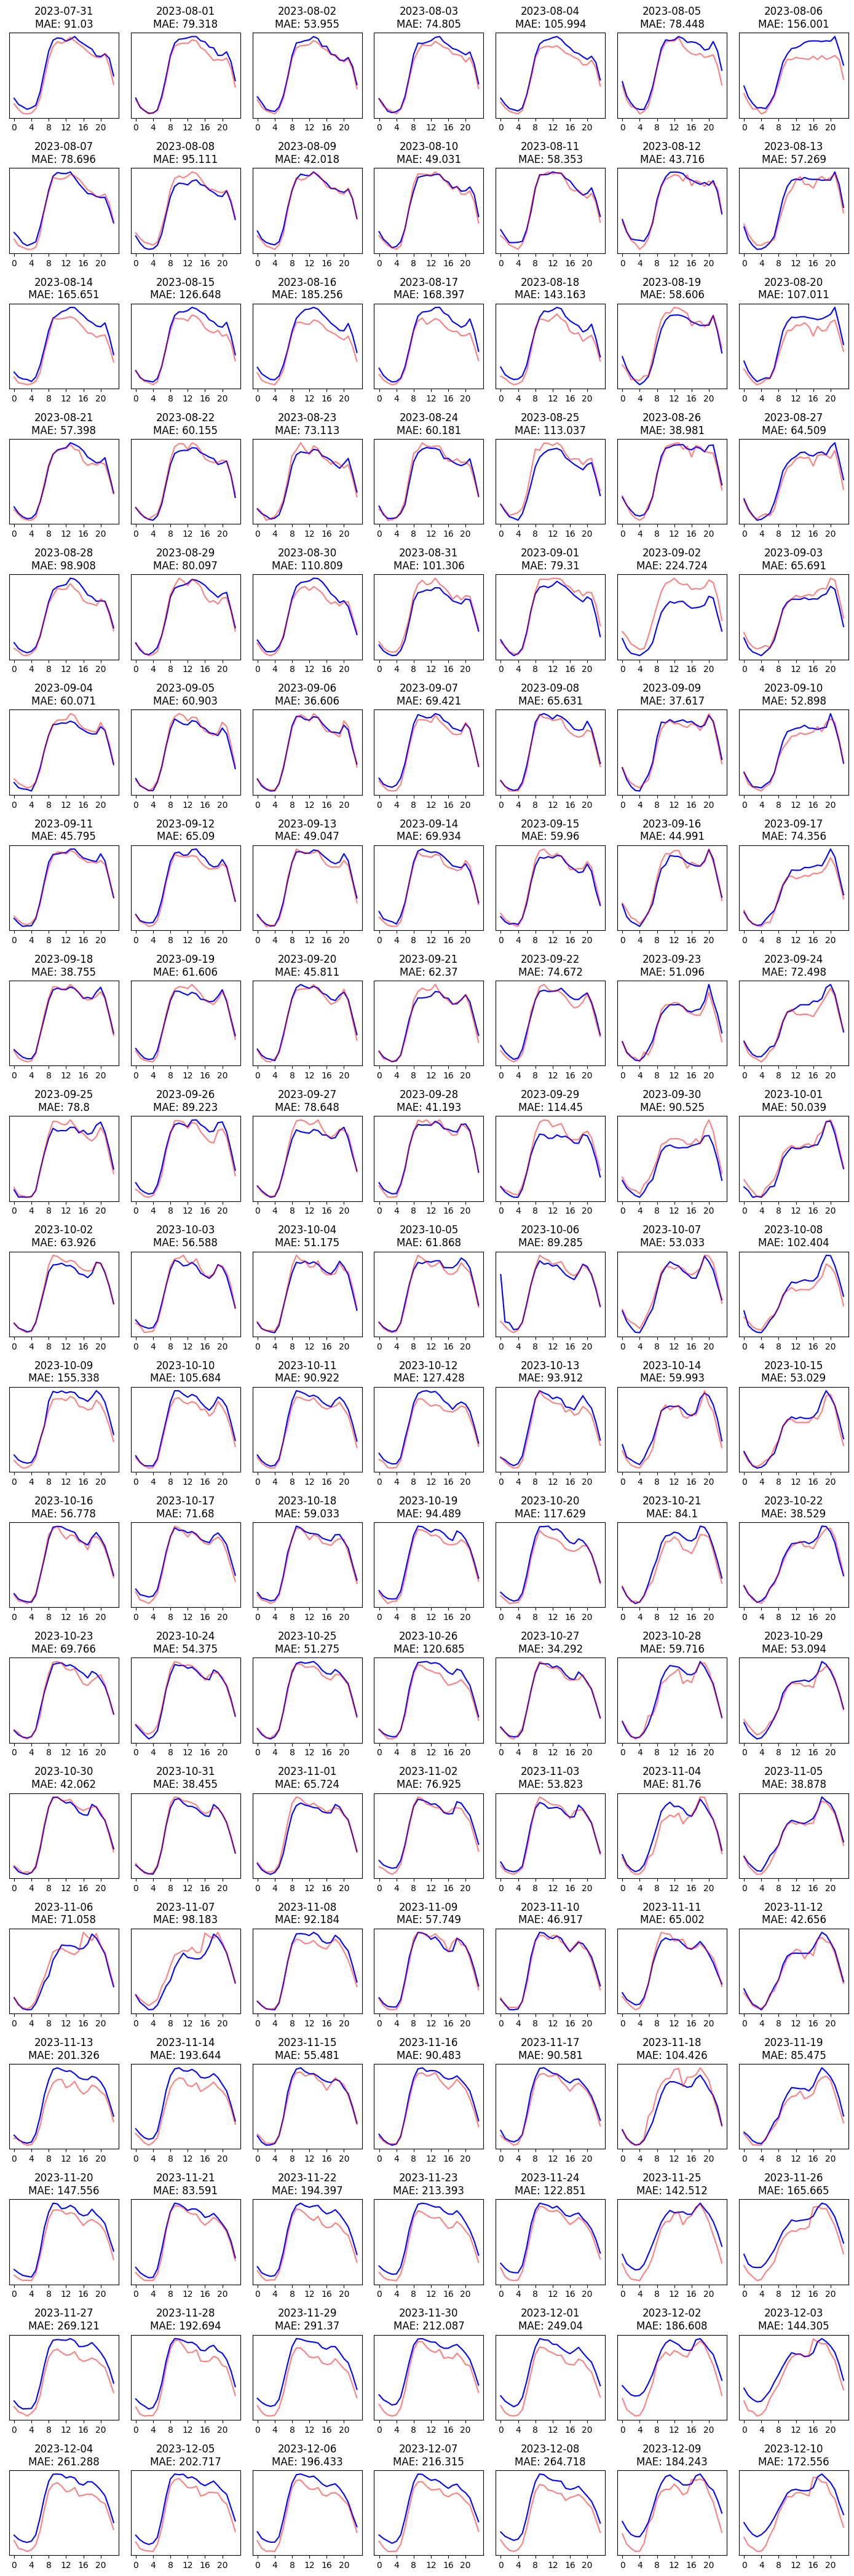

In [29]:
plot_predicts(df_true=global_y_test,
              df_pred=global_y_test_pred,
              days_shift=1)

In [30]:
model_object

{12: LGBMRegressor(max_depth=10, n_estimators=1000, random_state=0),
 13: LGBMRegressor(max_depth=2, n_estimators=500, random_state=0),
 14: LGBMRegressor(max_depth=8, n_estimators=1000, random_state=0),
 15: LGBMRegressor(max_depth=6, n_estimators=1000, random_state=0),
 16: LGBMRegressor(max_depth=8, n_estimators=1000, random_state=0),
 17: LGBMRegressor(max_depth=7, n_estimators=500, random_state=0),
 18: LGBMRegressor(max_depth=4, n_estimators=1000, random_state=0),
 19: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 20: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 21: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 22: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 23: LGBMRegressor(max_depth=1, n_estimators=1000, random_state=0),
 24: LGBMRegressor(max_depth=2, n_estimators=500, random_state=0),
 25: LGBMRegressor(max_depth=2, n_estimators=1000, random_state=0),
 26: LGBMRegressor(max_depth=1, n_estimators=1000,

In [31]:
with open(f'../new_models/lgbm_model.pickle', 'wb') as file:
    pickle.dump(model_object, file)